In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [2]:
data_path = r"/Users/pranavi/Downloads/Data Science/Garbage Data/Garbage classification/Garbage classification"

In [3]:
img_size = 120

In [4]:
img_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

In [5]:
img_data = ImageFolder(root=data_path, transform=img_transform)

In [6]:
img_data.class_to_idx

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [7]:
len(img_data)

2527

In [8]:
train_data, val_data, test_data = random_split(img_data,[1800,627,100])

In [9]:
len(train_data)

1800

In [10]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [11]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 120, 120]) torch.Size([32])


In [12]:
def show_img_batch(data):
    for images, labels in data:
        plt.figure(figsize=(20,15))
        plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
        plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


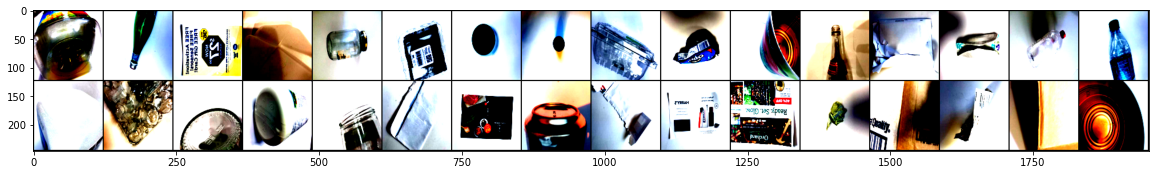

In [13]:
show_img_batch(train_loader)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3) #120-3+1 =118
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) #59-3+1 = 57
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3) #28-3+1 = 26
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(13*13*48,560)
        self.fc2 = nn.Linear(560, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,6)
        
    def forward(self,x):
        x = self.conv1(x) #118*118*16
        x = self.relu(x)
        x = self.pool(x) #59*59*16
        x = self.conv2(x) #57*57*32
        x = self.relu(x)
        x = self.pool(x) # 28*28*32
        x = self.conv3(x) #26*26*48
        x = self.relu(x)
        x = self.pool(x) #13*13*48
        x = x.view(-1, 13*13*48)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        
        return x
        

In [15]:
model = CNN()
print(model.parameters)

<bound method Module.parameters of CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=8112, out_features=560, bias=True)
  (fc2): Linear(in_features=560, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=6, bias=True)
)>


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [17]:
def CNN_train(loss_fn, optimizer):
    
    epochs=20
    
    training_loss = []
    training_acc = []
    testing_loss =[]
    testing_acc = []
    
    for epoch in range(epochs):
        
        train_acc = 0.0
        train_loss = 0.0
        
        model.train()
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            
            loss.backward()
            optimizer.step()
            
            predictions = torch.argmax(output, 1)
            
            train_acc += (predictions==labels).sum().item()
            train_loss += loss.item()
            
        training_acc.append(train_acc/len(train_data))
        training_loss.append(train_loss/len(train_loader))
        
        model.eval()
        
        test_acc = 0.0
        test_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                output = model(images)
                loss = loss_fn(output, labels)
                
                predictions = torch.argmax(output,1)
                
                test_acc += (predictions==labels).sum().item()
                test_loss += loss.item()
            
            testing_acc.append(test_acc/len(val_data))
            testing_loss.append(test_loss/len(val_loader))
            
            print("Epochs:{}, Training Accuracy:{:.2f}, Training Loss:{:.2f}, Testing Accuracy:{:.2f}, Testing Loss:{:.2f}".format(
            epoch+1, train_acc/len(train_data), train_loss/len(train_loader), test_acc/len(val_data), 
                test_loss/len(val_loader)))
            
            
    plt.title("Accuracy Vs Epochs")
    plt.plot(range(epochs), traning_acc, label="Training Accuracy")
    plt.plot(range(epochs), testing_acc, label="Testing Accuracy")
    plt.xlabel("Accuracy")
    plt.ylabel("Epochs")
    plt.legend()
    plt.show()
    
    plt.title("Loss Vs Epochs")
    plt.plot(range(epochs), testing_loss, label="Testing Loss")
    plt.plot(range(epochs), training_loss, label="Training Loss")
    plt.xlabel("Loss")
    plt.ylabel("Epochs")
    plt.legend()
    plt.show()
            

In [18]:
CNN_train(loss_fn, optimizer)

Epochs:1, Training Accuracy:0.19, Training Loss:1.80, Testing Accuracy:0.20, Testing Loss:1.80
Epochs:2, Training Accuracy:0.19, Training Loss:1.80, Testing Accuracy:0.20, Testing Loss:1.80
Epochs:3, Training Accuracy:0.19, Training Loss:1.80, Testing Accuracy:0.20, Testing Loss:1.79
Epochs:4, Training Accuracy:0.19, Training Loss:1.80, Testing Accuracy:0.20, Testing Loss:1.79
Epochs:5, Training Accuracy:0.19, Training Loss:1.79, Testing Accuracy:0.20, Testing Loss:1.79
Epochs:6, Training Accuracy:0.19, Training Loss:1.79, Testing Accuracy:0.20, Testing Loss:1.79
Epochs:7, Training Accuracy:0.19, Training Loss:1.79, Testing Accuracy:0.20, Testing Loss:1.79


KeyboardInterrupt: 